# Explaining ANN (Classification) to identify depression

## Import all necessary libraries

Of the following imports, the most important libraries are: sklearn.neural_network and sklearn.metrics.

In [65]:
import joblib
import dice_ml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from alibi.explainers.ale import ALE, plot_ale

## Defining global variables

The following variables defined below can be modified according to the given approach.

In [66]:
## Global variable designated for data loading.
df = pd.read_csv("Dataset_MO_ENG.csv")

## Global variables designated for threshold control.
positive_threshold = 0.01
negative_threshold = -0.01

## Defining private variables

The following variables defined below cannot be modified since they are an integral part of its operation.

In [67]:
## Private variables for the neural network by classification.
class_dic = { 1: 0 , 2: 0, 3:1, 4:2, 5:2}
target_namesbase = ["Low", "Medium", "High"]

## Private variables for oversample.
random_state = 13
oversample = SMOTE(random_state=random_state)

## Private variables for neural network generation.
seed = 1
regul_param_range = 10.0 ** -np.arange(-2, 7)

## Preparing the data for the neural network

The data is prepared in order to be processed by the neural network.

In [68]:
## Eliminating physical-related questions in dataset.
df = df.drop(df.columns[102:-1], axis=1)

## Grouping of the target according to the defined dictionary.
df ['Target'] = df ['Target'].map(class_dic)

## Assignment of local variables according to the data necessary for the neural network.
train_colsbase = df_base.columns [0:-1]
labelbase = df_base.columns [-1]
X = df [train_colsbase]
y = df [labelbase]

## The prepared data of the dataset is printed.
df

,1. Most of the time I have difficulty concentrating on simple tasks,2. I don't feel like doing my daily duties,3. My friends or family have told me that I look different,4. When I think about the future it is difficult for me to imagine it clearly,5. People around me often ask me how I feel,6. I consider that my life is full of good things,7. My hobbies are still important to me,8. I'm still as punctual as I have always been,"9. If I had the chance, I would spend all day in my bed",10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular,...,94. I lose control easily,95. Neighbors must put up with each other's noises without complaining,96. Littering on public roads is wrong,97. People who commit crimes have their reasons for doing it,98. It is normal to change jobs several times a year,99. It is important to respect turns,100. I could pretend to be someone else to achieve what I want,101. I consider it important that all people have the same rights,"102. I have a hard time taking ""no"" for an answer",Target
0,1,1,0,1,0,1,1,1,0,0,...,1,1,0,0,1,0,1,0,1,0
1,1,0,1,1,0,1,1,1,0,0,...,0,1,0,0,1,0,1,1,0,0
2,0,0,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,1,0,1,1
3,0,0,0,1,0,1,1,1,1,0,...,0,1,0,1,1,0,1,0,1,2
4,1,1,0,1,0,1,0,1,1,1,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1,1,1,0,0,1,1,1,0,1,...,0,1,1,1,1,1,1,0,1,2
100,1,1,0,0,1,1,1,0,0,0,...,0,1,0,1,1,0,0,0,0,1
101,0,0,1,1,1,1,1,0,1,1,...,0,1,0,0,1,1,1,1,1,0
102,1,0,0,0,1,1,1,1,1,1,...,0,1,1,0,1,0,1,1,0,2


## Oversample application

An oversample process is applied to level the amount of existing data given by the grouping.

In [69]:
## The number of elements present in the grouped target is printed.
y.value_counts()

0    39
1    35
2    30
Name: Target, dtype: int64

In [70]:
## Application of the oversample to the prepared data.
X, y = oversample.fit_resample(X, y)

In [71]:
## The results obtained after applying the oversample are printed.
y.value_counts()

0    39
1    39
2    39
Name: Target, dtype: int64

## Preparation of the parameters of the neural network

We proceed to define the parameters necessary for the training of the neural network.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seedbase)

## Neural network training

The alpha parameters and the initial learning rate are adjusted to obtain the best performance with the model
using cross validation.

In [73]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=regul_param, 
             learning_rate='constant', learning_rate_init=0.0001, max_iter=100000, random_state=seed)
    
    scores = cross_val_score(mlp, X, y, cv=5, scoring='f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
## The results obtained during the training are printed.
cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.4763355552829237,
  0.4513935101705999,
  0.46248242125951106,
  0.4691799342728135,
  0.4691799342728135,
  0.4691799342728135,
  0.4691799342728135],
 [0.006020651927912844,
  0.006020651927912844,
  0.09918844066715299,
  0.08068804784278276,
  0.09270871998125078,
  0.08309589200633044,
  0.08309589200633044,
  0.08309589200633044,
  0.08309589200633044])

We proceed to draw the learning curve graph according to the data obtained by the training.

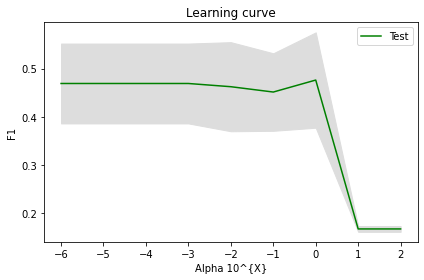

In [74]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color="g", label="Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color="#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Alpha 10^{X}"), plt.ylabel("F1"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

The training is performed again keeping the same parameters except for the alpha value that changes to 1.

In [75]:
## Local variables are defined for the storage of the scores obtained by the training.
cv_scores_mean = []
cv_scores_std = []

## Training and validation of different configurations.
for regul_param in regul_param_range:
    
    ## Increase the max_iter parameter until it converges.
    mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=1, 
             learning_rate='constant', learning_rate_init=regul_param, max_iter=100000, random_state=seed)
    
    scores = cross_val_score(mlp, X, y, cv=5, scoring='f1_macro')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([0.16659498207885304,
  0.16659498207885304,
  0.16659498207885304,
  0.46703181808444966,
  0.45220030972352954,
  0.4405739461776614,
  0.4763355552829237,
  0.16659498207885304,
  0.16659498207885304],
 [0.006020651927912844,
  0.006020651927912844,
  0.006020651927912844,
  0.0700006268704352,
  0.09521251410308869,
  0.0887293445552907,
  0.09918844066715299,
  0.006020651927912844,
  0.006020651927912844])

We proceed to draw the learning curve graph according to the data obtained by the training.

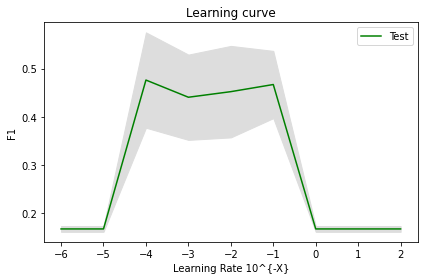

In [76]:
## The average accuracy line is drawn on the test parts.
plt.plot(np.log10(regul_param_range), cv_scores_mean, color="g", label="Test")

## The standard deviation band is drawn.
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color="#DDDDDD")

## Generate the graph.
plt.title("Learning curve")
plt.xlabel("Learning Rate 10^{-X}"), plt.ylabel("F1"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Generation of the neural network model

The parameters of the final model are modified according to the data obtained in the training of the neural network.

In [77]:
## The value of the alpha parameter is kept at 1 as well as the value of the seed of random_state at 77.
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', alpha=1, 
             learning_rate='constant', learning_rate_init=0.0001, max_iter=100000, random_state=77)

## We print the data of the final generated model.
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1, hidden_layer_sizes=(10,),
              learning_rate_init=0.0001, max_iter=100000, random_state=77)

We safeguard the final generated model

In [78]:
joblib.dump(mlp,"model_depression.pkl")

['model_depression.pkl']